In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf
%matplotlib inline

np.random.seed(3)
tf.random.set_seed(3)

In [2]:
rp = pd.read_csv('DP_result.csv')
rp = pd.DataFrame(rp)
rp = rp[(rp['y_pred']==1) & (rp['y_real']==1)]

In [3]:
persons=list(set(rp['person_id'].tolist()))
persons.sort()

In [ ]:
cs = pd.read_csv('Initial Care History.csv') # Initial Care History table
cs = pd.DataFrame(cs)

cancer = cs['current_status']==1
cs_c = cs[cancer]

### Convert 2D array

In [5]:
new = pd.DataFrame(columns=['person_id', 'rnn', 'y_pred', 'y_real', 'gender', 'age', 'test_age',
       'EGD', 'bmi', 'alcohol_habit', 'smoking status', 'smoking_duration',
       'amount of smoking', 'income', 'family_cancer', 'current_status',
       'exercise', 'cancer', 'date'])

for p in persons:
    ap = rp['person_id']==p
    ap_df = rp[ap]
    ap_leng = len(ap_df)
    
    if ap_leng == 1:
        new = new.append(ap_df)
    elif ap_leng >= 2:
        lengths =[]
        #print(p)
        cs_p = (cs_c[cs_c['person_id']==p]).iloc[0,3] # cancer of the stomach Date
        cs_p = pd.to_datetime(cs_p)
        
        for i in range(ap_leng):
            ap_p = (ap_df.iloc[i,15]) # Date of initial care recorded on the patient
            ap_p = pd.to_datetime(ap_p)
            if cs_p == ap_p:
                ap_pp = (ap_df.iloc[i,16]) # Health check up date recorded for the patient
                ap_pp = pd.to_datetime(ap_pp)
                # Compare with date of initial gastric cancer treatment, then compare date of health check up and difference
                lengths.append(abs((ap_pp-cs_p).days)) 
            else:
                lengths.append(99999) # Replace NULL value if initial care date is different
                
        min_p = lengths.index(min(lengths)) # Find and enter health check up records with the smallest date difference
        new = new.append(ap_df.iloc[min_p,:])
        
        

### Replace Null value

In [6]:
new.loc[:,list(new.loc[:,new.isnull().any()].columns)].isnull().sum()/(len(new))*100

EGD         81.720430
bmi         31.182796
income       1.075269
exercise     1.075269
dtype: float64

In [7]:
new = new.replace({'EGD':np.nan},{'EGD':0})
new = new.replace({'bmi':np.nan},{'bmi':round((new['bmi']).mean(),2)})
new = new.replace({'income':np.nan},{'income':(new['income']).median()})
new = new.replace({'exercise':np.nan},{'exercise':0})

In [8]:
p_id = new['person_id']
rnn = new['rnn']

### K-means

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

new1 = new[['gender','age','test_age','EGD','bmi','alcohol_habit','smoking status','smoking_duration','amount of smoking','income','family_cancer','current_status','exercise']]

#### StandardScaler & PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2).fit(new1)
result = pca.transform(new1)

result = pd.DataFrame(result, columns=["x", "y"])
#result

In [11]:
from sklearn.pipeline import make_pipeline

ks = range(1,11)
inertias=[]

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(result)
    inertias.append(model.inertia_)

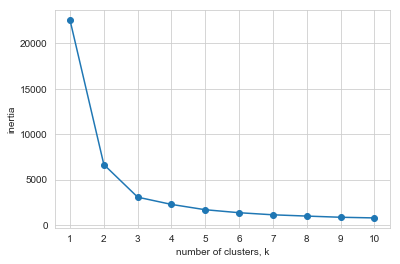

In [12]:
plt.plot(ks,inertias,'-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.draw()

In [16]:
model2 = KMeans(n_clusters=3)
model2.fit(new1)
result['cluster3_label'] = model2.labels_
new['cluster3_label'] = model2.labels_

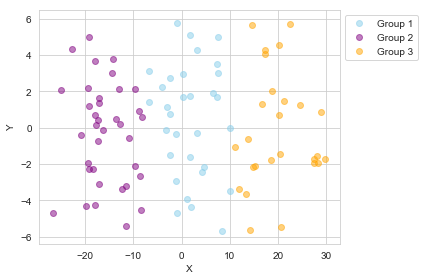

In [17]:
l = ['Group 1','Group 2','Group 3']
c = ['skyblue','purple','orange']
for i in range(3):
    tick = result[result['cluster3_label']==i]
    plt.scatter(tick['x'],tick['y'],marker="o",color=c[i],label=l[i],alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.draw()

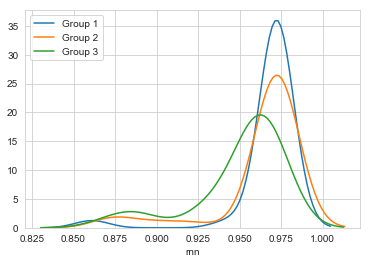

In [18]:
group1 = new[new['cluster3_label']==0]
group2 = new[new['cluster3_label']==1]
group3 = new[new['cluster3_label']==2]

sns.distplot(group1['rnn'],label='Group 1', bins=10,kde=True,hist=False)
sns.distplot(group2['rnn'],label='Group 2',bins=10,kde=True,hist=False)
sns.distplot(group3['rnn'],label='Group 3',bins=10,kde=True,hist=False)

plt.legend(loc='upper left')
plt.draw()

In [19]:
from mpl_toolkits.mplot3d import Axes3D

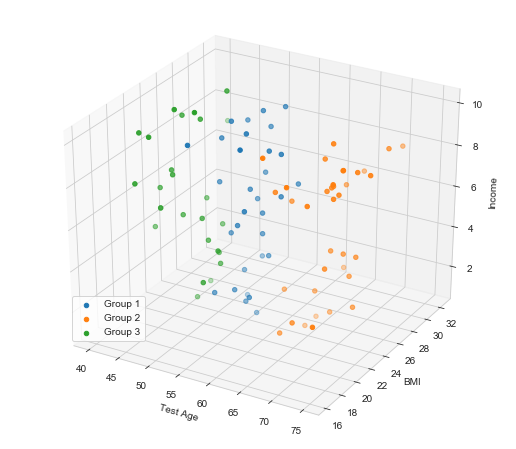

In [20]:
fig = plt.figure(figsize=(9,8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(group1['test_age'],group1['bmi'],group1['income'],"o",label="Group 1")
ax.scatter(group2['test_age'],group2['bmi'],group2['income'],"o",label="Group 2")
ax.scatter(group3['test_age'],group3['bmi'],group3['income'],"o",label="Group 3")
ax.set_xlabel('Test Age')
ax.set_ylabel('BMI')
ax.set_zlabel('Income')

plt.legend(loc="lower left",bbox_to_anchor=(0.12,0.22))
plt.draw()

In [21]:
new = new.replace({'cluster3_label':0},{'cluster3_label':'Group 1'})
new = new.replace({'cluster3_label':1},{'cluster3_label':'Group 2'})
new = new.replace({'cluster3_label':2},{'cluster3_label':'Group 3'})

In [22]:
new = new.reset_index().set_index('cluster3_label')
new = new.sort_index()
new = new.reset_index().set_index('index')

In [23]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

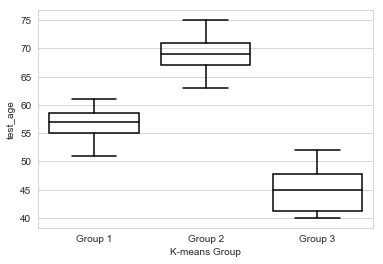

In [24]:
sns.boxplot(x='cluster3_label',y='test_age', data=new,  **PROPS)
plt.xlabel('K-means Group')

plt.draw()

In [25]:
#new.to_csv('kmeans_result.csv',mode='w',index=False)